In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,StratifiedKFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [2]:
# Load the wine dataset
wine = datasets.load_wine()

X, y = wine.data, wine.target

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Assignment
Use at least 3 appropriate models for predictions on the wine dataset
- logistic regression
- random forest
- support vector machines

Pack your models into their respective pipelines and evaluate their results.

#### Define, create, and fit pipelines

In [15]:
pipe_logit = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(random_state=42))
])
pipe_logit.fit(X=X_train, y=y_train)
pipe_rf = Pipeline([
    ('pca', PCA(n_components=2)),
    ('clf', GridSearchCV(
        estimator=RandomForestClassifier(random_state=42),
        param_grid={
            "n_estimators": [25, 50, 75, 100],
            "min_samples_split": [2, 3, 4, 5],
            "min_samples_leaf": [1,2,3]}, 
        cv=5, verbose=0)
    )
])
pipe_rf.fit(X=X_train, y=y_train)
pipe_svc = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('clf', SVC(random_state=42))
])
pipe_svc.fit(X=X_train, y=y_train)

Pipeline(steps=[('poly', PolynomialFeatures()), ('clf', SVC(random_state=42))])

Note that we chose different pre-processing steps: Standard Scalling for the Logistic pipeline, PCA for the RF pipeline, and PolynomialFeatures for SVC.

Additionally, we chose to fine-tune the hyperparameters of the RF classifier using GridSearch while leaving the logistic regression and SVC with the default hyperparameters.

#### Validation

Once our estimators are trained and hyperparameters tuned, it is time to estimate their predictive performance. To this end, since the dataset is not perfectly balanced we choose to use the Stratified K-Fold cross-validation technique.

In [16]:
estimators = [pipe_logit, pipe_rf, pipe_svc]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for estimator in estimators:
    kfold_scores = cross_val_score(estimator, X_train, y_train, cv=skf)
    print(f"{estimator.named_steps['clf'].__class__.__name__} - Avg. accuracy={np.mean(kfold_scores):.2f}")

LogisticRegression- Avg. accuracy=0.97
GridSearchCV- Avg. accuracy=0.75
SVC- Avg. accuracy=0.66


From the above performance estimates, you may decide to change the data you use, the preprocessing steps (transformations, feature engineering, ...etc), or improve the fune-tuning of hyperparameters.

#### Test

Once you are happy with your estimators and their estimated performances, you now want to know the final performance of your estimators, the one that you will announce to your client or manager. This is done using the test set.

NOTE: You shouldn't use the test set performance estimates to change again your pipeline setup, this would lead you to overfit the test set in the end.

In [17]:
# Evaluate the Logistic Regression pipeline
lr_pred = pipe_logit.predict(X_test)
acc_lr = accuracy_score(y_test, lr_pred)
print(f"Logistic Regression Accuracy: {acc_lr:.2f}")

# Evaluate the Random Forest pipeline
rf_pred = pipe_rf.predict(X_test)
acc_rf = accuracy_score(y_test, rf_pred)
print(f"Random Forest Accuracy: {acc_rf:.2f}")

# Evaluate the Support Vector Machine pipeline
svc_pred = pipe_svc.predict(X_test)
acc_svc = accuracy_score(y_test, svc_pred)
print(f"Support Vector Classifier Accuracy: {acc_svc:.2f}")


Logistic Regression Accuracy: 1.00
Random Forest Accuracy: 0.78
Support Vector Classifier Accuracy: 0.78


In [18]:
# Determine the best-performing model
best_acc = max(acc_lr, acc_rf, acc_svc)
best_model = ['Logistic Regression', 'Random Forest', 'SVC'][[acc_lr, acc_rf, acc_svc].index(best_acc)]

print(f"The best-performing model is: {best_model} with an accuracy of {best_acc:.2f}")

The best-performing model is: Logistic Regression with an accuracy of 1.00


#### Visualization of the RF Classifier decision rules

To this end, we use the two first PCA eigenvectors. Note that it is not possible to do it with the other classifiers with the current pipelines setup.

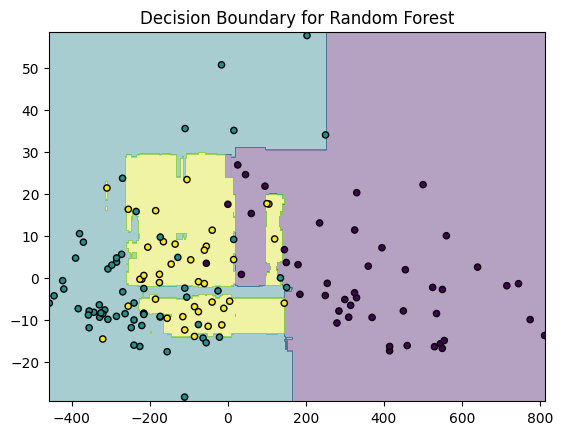

In [19]:
# Function to plot decision boundaries for the 2D PCA pipeline
def plot_decision_boundaries(X, y, model, ax, title):
    # Plotting decision regions
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
    ax.set_title(title)

# Plot decision boundary for the Random Forest model
fig, ax = plt.subplots()
X_train_pca = pipe_rf.named_steps['pca'].transform(X_train)
plot_decision_boundaries(
    X=X_train_pca,
    y=y_train,
    model=pipe_rf.named_steps['clf'],
    ax=ax,
    title="Decision Boundary for Random Forest"
)
plt.show()